<a href="https://colab.research.google.com/github/google/jax-md/blob/master/notebooks/nve_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Imports & Utils

!pip install jax-md

import numpy as onp

from jax.config import config ; config.update('jax_enable_x64', True)
import jax.numpy as np
from jax import random
from jax import jit
from jax import lax

import time

from jax_md import space, smap, energy, minimize, quantity, simulate

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
  
sns.set_style(style='white')

def format_plot(x, y):  
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

     |████████████████████████████████| 61kB 4.4MB/s 
     |████████████████████████████████| 245kB 12.8MB/s 


# Constant Energy Simulation


Here we demonstrate some code to run a simulation at constant energy. We start off by setting up some parameters of the simulation.

In [2]:
N = 5000
dimension = 2
box_size = 80.0
displacement, shift = space.periodic(box_size) 

Next we need to generate some random positions as well as particle sizes.

In [3]:
key = random.PRNGKey(0)

In [4]:
R = random.uniform(
    key, (N, dimension), minval=0.0, maxval=box_size, dtype=np.float64)

# The system ought to be a 50:50 mixture of two types of particles, one
# large and one small.
sigma = np.array([[1.0, 1.2], [1.2, 1.4]])
N_2 = int(N / 2)
species = np.where(np.arange(N) < N_2, 0, 1)

Then we need to construct our simulation operators.

In [6]:
energy_fn = energy.soft_sphere_pair(
    displacement, species=species, sigma=sigma)
init, apply = simulate.nve(energy_fn, shift, 1e-2)
step = jit(lambda i, state: apply(state))
state = init(key, R, velocity_scale=0.0)

Now let's actually do the simulation. We'll keep track of potential energy and kinetic energy as the simulation progresses.

In [9]:
PE = []
KE = []

print_every = 1
old_time = time.clock()
print('Step\tKE\tPE\tTotal Energy\ttime/step')
print('----------------------------------------')

for i in range(20):
  state = lax.fori_loop(0, 10, step, state)
  
  PE += [energy_fn(state.position)]
  KE += [quantity.kinetic_energy(state.velocity)]
  
  if i % print_every == 0 and i > 0:
    new_time = time.clock()
    print('{}\t{:.2f}\t{:.2f}\t{:.3f}\t{:.2f}'.format(
        i * print_every, KE[-1], PE[-1], KE[-1] + PE[-1], 
        (new_time - old_time) / print_every / 10.0))
    old_time = new_time

PE = np.array(PE)
KE = np.array(KE)
R = state.position

Step	KE	PE	Total Energy	time/step
----------------------------------------
1	445.48	290.11	735.590	0.12
2	446.57	289.02	735.590	0.06
3	447.74	287.85	735.590	0.06
4	448.68	286.91	735.590	0.06
5	449.18	286.41	735.590	0.06
6	449.31	286.28	735.590	0.06
7	449.07	286.52	735.590	0.06
8	448.53	287.06	735.590	0.06
9	447.76	287.83	735.590	0.06
10	446.81	288.78	735.590	0.06
11	445.71	289.88	735.590	0.06
12	444.44	291.15	735.590	0.06
13	442.91	292.68	735.590	0.06
14	441.16	294.43	735.591	0.06
15	439.29	296.30	735.591	0.06
16	437.56	298.04	735.591	0.06
17	436.12	299.47	735.591	0.06
18	435.15	300.44	735.591	0.06
19	434.63	300.96	735.591	0.06


Now, let's plot the energy as a function of time. We see that the initial potential energy goes down, the kinetic energy goes up, but the total energy stays constant.

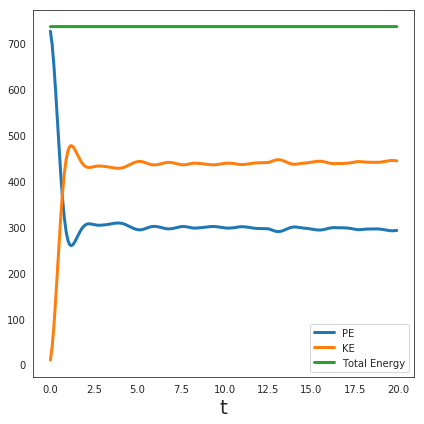

In [ ]:
t = onp.arange(0, 2000, 10) * 1e-2
plt.plot(t, PE, label='PE', linewidth=3)
plt.plot(t, KE, label='KE', linewidth=3)
plt.plot(t, PE + KE, label='Total Energy', linewidth=3)
plt.legend()
format_plot('t', '')
finalize_plot()

Now let's plot the system.

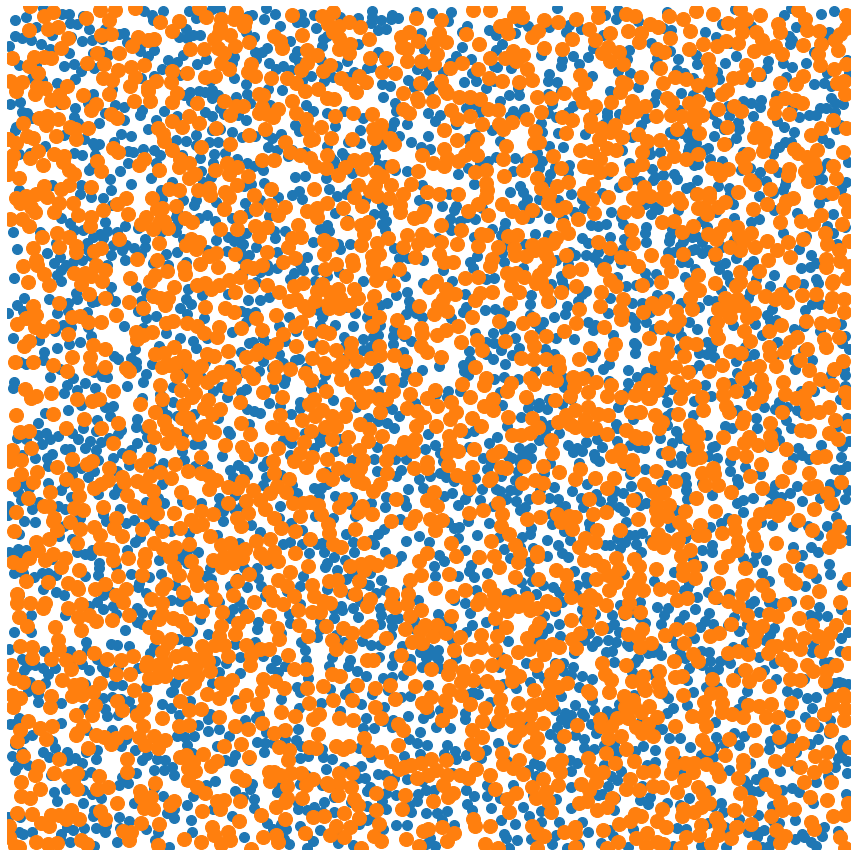

In [10]:
ms = 20
R_plt = onp.array(state.position)

plt.plot(R_plt[:N_2, 0], R_plt[:N_2, 1], 'o', markersize=ms * 0.5)
plt.plot(R_plt[N_2:, 0], R_plt[N_2:, 1], 'o', markersize=ms * 0.7)

plt.xlim([0, np.max(R[:, 0])])
plt.ylim([0, np.max(R[:, 1])])

plt.axis('off')

finalize_plot((2, 2))